# __Analysing Trends in Citibike NYC Rides__

#### __Team Details__- Team 1 from BA 843 course (3:30 PM- 6:15 PM)
#### __Group Members__- Sindhura Uppalapati, Ziyin Chen, Zhaner Sun, Yiping Ren

## __Main Contents__
* Objective and Motivation
* Dataset Information
* Brief Introduction to Dataset
* EDA and Preprocessing
* Analysis
* Clustering
* Conclusions and References

## __Objective__
The project aims to analyze and visualize the trends and patterns in Citibike NYC rides in 2022. The project seeks to identify insights that could help improve the bike-sharing system and can potentially improve the bike-sharing experience for users by making sure the bikes are available and usable.

## **Motivation**
Bicycling has gained popularity as an alternative mode of transportation, and Citibike NYC is one of the largest bike-sharing systems in the world. Analyzing the patterns and trends in Citibike NYC rides could provide insights that could help improve the bike-sharing system and encourage more people to use bicycles as a means of transportation.

## **Executive Summary**

The project analyzed the patterns and trends of Citibike NYC rides in 2022 and identified several key action steps. The most popular round trips were observed to start and end at Central Park and 7th Ave, indicating the need for resource optimization in these areas during peak usage times. Efforts could also be made to promote electric bike services and focus on subscriber retention and acquisition by running appropriate promotions in the peak hours. By analyzing station demand clusters, it was observed that high-demand stations required more frequent servicing and maintenance. Improvements to infrastructure, such as increasing station capacity and optimizing bike availability, could be made in downtown areas with busy stations. Finally, dynamic rebalancing strategies could be employed at stations with a high imbalance of outgoing and incoming bikes to optimize bike availability during peak usage times.


## **Dataset Source and Brief Introduction**

We're using the bike trips data available on the Citibike NYC website for our analysis. This data contains information on bike trips taken by users of the Citibike bike-sharing system in New York City. 

Link to the dataset is https://www.citibikenyc.com/system-data 

The dataset was available from 2013 but had a revamp after 2018 which removed user identification information. Since the data size is huge we've decided to use only data from 2022 since it helps us understand the most recent trend and 2022 alone is around 8GB of data.

* __citibike_tripdata__ contains information on individual bike trips, including trip duration, start and end time, start and end stations. 
    Dimensions- 31 million rows by 13 columns
    Data Size- About 7.8 GB.
    Columns- Here's a short overview of these columns-
    Ride ID: A unique identifier assigned to each ride.

  * Rideable type: The type of vehicle used for the ride, such as a classic bike, electric bike, or docked. (explained in detail later)

  * Started at/Ended at: The date and time when the ride started/ended.

  * Start/End station name: The name of the station where the ride started/ended.

  * Start/End station ID: A unique identifier assigned to the station where the ride started/ended.

  * Start/End latitude/longitude: The latitude/longitude coordinate of the station where the ride started/ended.

  * Member or casual ride: Indicates whether the ride was taken by a member (someone with a subscription or membership) or a casual user (someone who rented a vehicle without a subscription).

## **1. Data Preprocessing and EDA**
Firstly, including all necessary libraries.

In [ ]:
from pyspark.sql.functions import col, isnan, when, count, to_timestamp, to_date, when
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

Since the latest data from our dataset isn't available on bigquery we've stored it on our cloud storage to access it. Here's the code for it

In [ ]:
data="gs://ba843team1/notebooks/jupyter/Data"

df = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "/2022*.csv")

In [ ]:
df.show(5)

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+------------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|         start_lat|         start_lng|           end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+------------------+------------------+-------------+
|55262E4365A955A2| classic_bike|2022-01-18 08:23:52|2022-01-18 08:28:18|Boerum Pl\t& Paci...|         4488.09|Clinton St & Jora...|       4605.04| 40.68848905639242|-73.99116039276123|       40.69239502|      -73.99337909|       member|
|D272F1B15D841EC0| classic_bike|2022-01-21 09:03:22|

In [ ]:
df.count()

30689921

We've close to 31 million records we're working with.

Let's look at the missing values in the records we just read.

In [ ]:
null_counts = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])

null_counts.show()

+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+
|ride_id|rideable_type|started_at|ended_at|start_station_name|start_station_id|end_station_name|end_station_id|start_lat|start_lng|end_lat|end_lng|member_casual|
+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+
|      0|            0|         0|       0|                50|              50|           71773|         71773|        0|        0|  37516|  37516|            0|
+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+



end_station_name and id have the highest missing values on 71773 followed by end station longitude and latitude. The reasons for these missing values could be a combination of an error in entry and people not returning their bicycles. 

Although start station has a minor number of missing values, it's interesting to note that the longitude and latitude of the start station have no missing values. 

71000 missing records out of 31 million rows is about 0.002% of the data which is not so bad. Any filling method would not make sense here so we decided to drop these NULL's

In [ ]:
df = df.dropna()
df.count()

30618148

Now, let's check the schema of our dataframe.

In [ ]:
df.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: string (nullable = true)
 |-- ended_at: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: string (nullable = true)
 |-- start_lng: string (nullable = true)
 |-- end_lat: string (nullable = true)
 |-- end_lng: string (nullable = true)
 |-- member_casual: string (nullable = true)



We can see that all the columns are currently of the string datatype because we didn't give a specific schema while loading this data. Now we know exactly what columns are there let's convert them to appropriate datatypes.

In [ ]:
df = df.withColumn('started_at', to_timestamp(col('started_at'), 'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn('ended_at', to_timestamp(col('ended_at'), 'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn('start_station_id', col('start_station_id').cast('integer'))
df = df.withColumn('end_station_id', col('end_station_id').cast('integer'))
df = df.withColumn('start_lat', col('start_lat').cast('double'))
df = df.withColumn('start_lng', col('start_lng').cast('double'))
df = df.withColumn('end_lat', col('end_lat').cast('double'))
df = df.withColumn('end_lng', col('end_lng').cast('double'))

df.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



Next, let's check if there are any duplicate rows. I grouped by all columns and then printed rows with count>1 to see if any two rows have the same values. We can see that there are none. 

In [ ]:
grouped_df = df.groupBy(df.columns).count()

duplicate_rows = grouped_df.filter("count > 1")

duplicate_rows.show()

+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+-----+
|ride_id|rideable_type|started_at|ended_at|start_station_name|start_station_id|end_station_name|end_station_id|start_lat|start_lng|end_lat|end_lng|member_casual|count|
+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+-----+
+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+-----+



Let's print the unique values in rideable_type and member_casual to check for any erreneous values.

In [ ]:
df.select('rideable_type').distinct().show()

+-------------+
|rideable_type|
+-------------+
|  docked_bike|
|electric_bike|
| classic_bike|
+-------------+



In [ ]:
df.select('member_casual').distinct().show()

+-------------+
|member_casual|
+-------------+
|       casual|
|       member|
+-------------+



Both these columns seem to be clean enough and have only the expected values. Let's create new columns for day of the week, start_hour, season, weekend flag, duration from the started and ended time stamps and distance from the coordinates.

In [ ]:
#duration in minutes
df = df.withColumn("duration", (col("ended_at").cast("long") - col("started_at").cast("long")) / 60) 

#distance in miles
df = df.withColumn("distance",
                   F.sqrt(F.pow((col("end_lat") - col("start_lat")) * 69, 2) +
                        F.pow((col("end_lng") - col("start_lng")) * 69 * F.abs(F.cos(F.radians(col("start_lat")))), 2)))

df = df.withColumn("dayofweek", F.date_format(df.started_at, "E"))
df = df.withColumn("weekend", when(col("dayofweek").isin(["Sat", "Sun"]), 1).otherwise(0))
df = df.withColumn("start_hour", F.hour("started_at"))
df = df.withColumn("stop_hour", F.hour("ended_at"))
df = df.withColumn("start_date", F.to_date("started_at"))
df = df.withColumn("stop_date", F.to_date("ended_at"))
df = df.withColumn("month", F.month("started_at"))
df = df.withColumn("season", 
                   when((F.col("month") >= 3) & (F.col("month") <= 5), 'Spring')
                   .when((F.col("month") >= 6) & (F.col("month") <= 8), 'Summer')
                   .when((F.col("month") >= 9) & (F.col("month") <= 11), 'Fall')
                   .otherwise('Winter'))

df.show(5)

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+------------------+------------------+-------------+------------------+-------------------+---------+-------+----------+---------+----------+----------+-----+------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|         start_lat|         start_lng|           end_lat|           end_lng|member_casual|          duration|           distance|dayofweek|weekend|start_hour|stop_hour|start_date| stop_date|month|season|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+------------------+------------------+-------------+------------------+-------------------+---------+-------+-------

Now that we have added all relevant derived columns let's go ahead and verify the numerical columns we derived in this step for it's distribution.

In [ ]:
df.select( "duration", "distance").describe().show()

+-------+-------------------+------------------+
|summary|           duration|          distance|
+-------+-------------------+------------------+
|  count|           30689921|          30652405|
|   mean|  17.25109356043431|1.1403833457434187|
| stddev|  89.16414262874434|1.0274877110597924|
|    min|-1130.1166666666666|               0.0|
|    max|  57985.98333333333| 18.31890141841419|
+-------+-------------------+------------------+



Although rest of the stats seems fine we can see the minimum value of duration is in negative, let's check how many of the values are negative

In [ ]:
print(df.filter(col("duration") < 0).count())

1206


Since it's a very small number of columns could be an error in updating. Let's drop these rows.

In [ ]:
df = df.filter(col("duration") >= 0)
df.select( "duration", "distance").describe().show()

+-------+------------------+------------------+
|summary|          duration|          distance|
+-------+------------------+------------------+
|  count|          30616944|          30616944|
|   mean|15.145352377428628|1.1398864917703824|
| stddev| 60.83901404173475|1.0263885465602145|
|    min|               0.0|               0.0|
|    max| 57985.98333333333|  18.2283318867517|
+-------+------------------+------------------+



Printed the description of our duration and distance column to make sure it's been updated correctly and makes sense.

Let's do a quick quality check for the remaining columns as well

In [ ]:
df.select("start_lat", "start_lng", "end_lat", "end_lng").describe().show()

+-------+------------------+-------------------+-------------------+--------------------+
|summary|         start_lat|          start_lng|            end_lat|             end_lng|
+-------+------------------+-------------------+-------------------+--------------------+
|  count|          30688715|           30688715|           30651199|            30651199|
|   mean|40.740862938294484| -73.97511191049436| 40.740647214160305|  -73.97520545384704|
| stddev|0.0391276387825244|0.02596384806573027|0.03906903396405851|0.025980875772785905|
|    min|      40.627368927|      -74.028018594|              40.56|              -74.28|
|    max|      40.883978248| -73.87858771666667|              41.06|              -73.75|
+-------+------------------+-------------------+-------------------+--------------------+



In [ ]:
df.selectExpr("min(started_at)", "max(started_at)").show()

+-------------------+-------------------+
|    min(started_at)|    max(started_at)|
+-------------------+-------------------+
|2022-01-01 00:00:13|2022-12-31 23:59:52|
+-------------------+-------------------+



In [ ]:
df.selectExpr("min(ended_at)", "max(ended_at)").show()

+-------------------+-------------------+
|      min(ended_at)|      max(ended_at)|
+-------------------+-------------------+
|2022-01-01 00:02:15|2023-01-02 19:42:11|
+-------------------+-------------------+



In [ ]:
df.cache()

DataFrame[ride_id: string, rideable_type: string, started_at: timestamp, ended_at: timestamp, start_station_name: string, start_station_id: int, end_station_name: string, end_station_id: int, start_lat: double, start_lng: double, end_lat: double, end_lng: double, member_casual: string, duration: double, distance: double, dayofweek: string, weekend: int, start_hour: int, stop_hour: int, start_date: date, stop_date: date, month: int, season: string]

Now that we've finished the quality check of the columns and made sure our data is cahched and ready for analysis. Let's move to the preliminary analysis we conducted.

## **2. Data Analysis/Visualizations**

In this section we've performed our preliminary exploration of our dataset to get an idea of any interesting trends and areas that we can concentrate on. We've divided theis anlysis into 5 questions we've tried to find answers for and plotted graphs to help us answer them.



###2.1. What stations are the most commonly used?

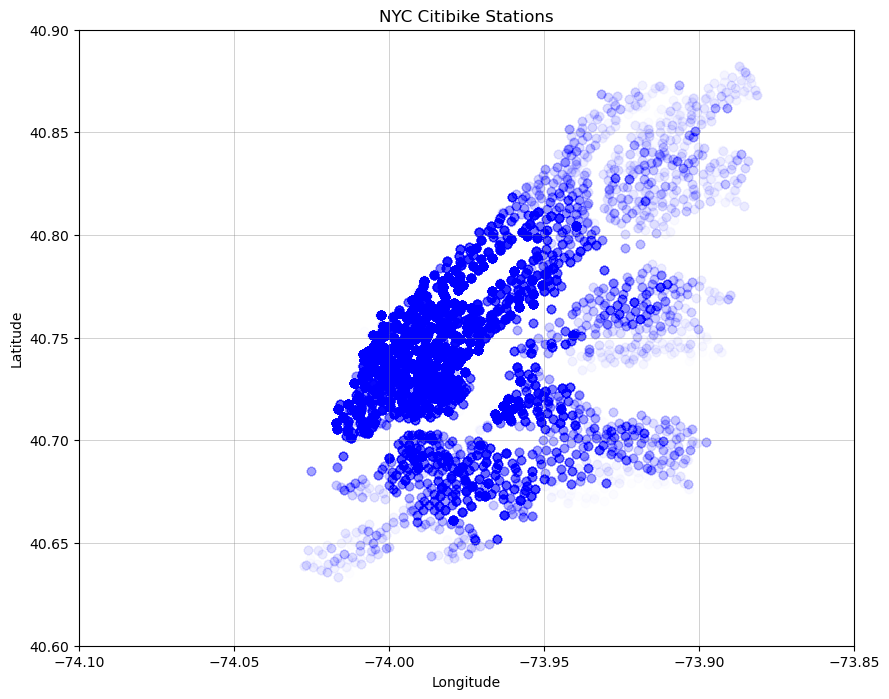

In [ ]:
trips_sample = df.select('start_lng', 'start_lat', 'end_lng', 'end_lat').sample(False, 0.005)

stations_pandas = trips_sample.toPandas()

plt.figure(figsize=(10,8))
plt.scatter(stations_pandas['start_lng'], stations_pandas['start_lat'], alpha=0.009, color='blue')
plt.scatter(stations_pandas['end_lng'], stations_pandas['end_lat'], alpha=0.001, color='blue')
plt.xlim(-74.1, -73.85)
plt.ylim(40.6, 40.9)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NYC Citibike Stations')
plt.grid(linestyle='-', linewidth='0.5', color='gray', alpha=0.5)
plt.show()

![image.png](http://www.streetsblog.org/wp-content/uploads/2015/07/citibike.png)

With this visualization we tried to analyze the most commonly used start stations in NY and their arrangement. **As expected we can see that most busy stations are flocked together in downtown NY.** The attached NY map is for reference to understand the other geographical factors causing this distribution.

We can use this data to try to improve the service in the frequently used areas as well as running ad campaigns at these locations to attract more subscribers.


### 2.2. What's the most busiest time during the week?

Text(0, 0.5, 'Number of trips')

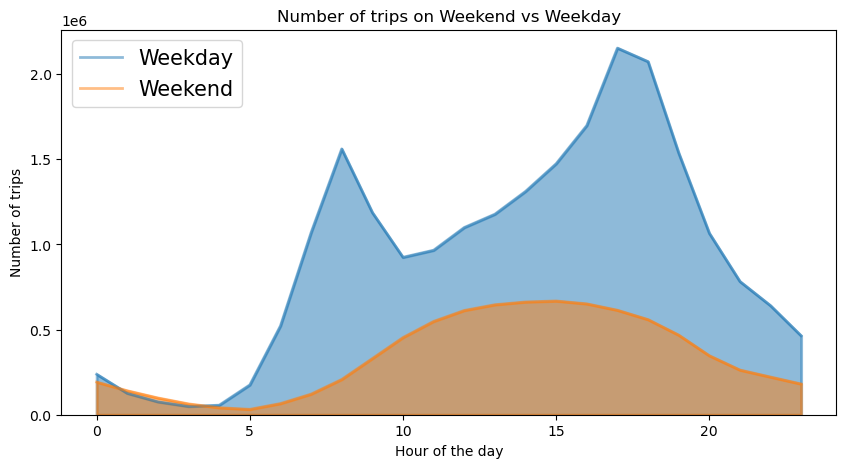

In [ ]:
grouped_weekend = df.groupBy("weekend", "start_hour")\
                    .agg({"ride_id": "count"}).withColumnRenamed("count(ride_id)", "num_trips")

# Pivot the dataframe to create a line chart
pivot_weekend = grouped_weekend.groupBy("start_hour").pivot("weekend").sum("num_trips").orderBy("start_hour")

weekend_pd=pivot_weekend.toPandas()

plt.rcParams.update({'font.size': 10, 'legend.fontsize': 15})
weekend_pd.plot(kind = 'area', x="start_hour", stacked = False, figsize = (10, 5), linewidth = 2)
plt.legend(['Weekday','Weekend'], loc='upper left')
plt.title('Number of trips on Weekend vs Weekday')
plt.xlabel('Hour of the day')
plt.ylabel('Number of trips')

We can see above that there's a stark difference between trends on the weekdays and weekends. The demand for citibikes is very low over the weekend. So, we decided to further analyse what are the peak hours during the weekdays by using a heatmap before we make any conclusions.

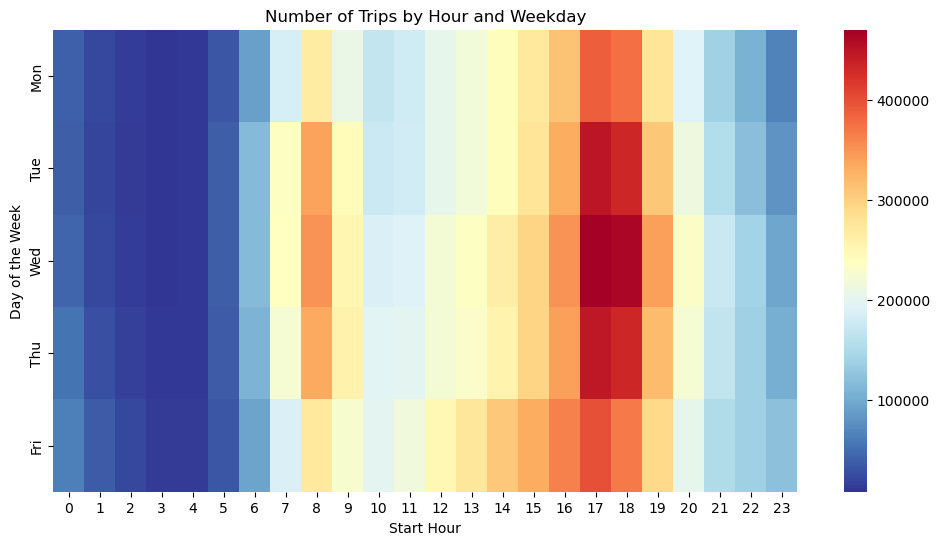

In [ ]:
#filtering weekday data
heatmap_data = df.filter(col("weekend") == 0)

# grouped by weekday and hour and counted the number of trips
heatmap_data = heatmap_data.groupBy("dayofweek", "start_hour").agg(F.count("*").alias("count")).orderBy("dayofweek", "start_hour")

#changed the dataframe to appropriate format for a heatmap
heatmap_matrix = heatmap_data.groupBy("dayofweek").pivot("start_hour").sum("count").fillna(0)

heatmap_matrix = heatmap_matrix.withColumn("dayofweek_order", when(col("dayofweek") == "Mon", 1)
                                                      .when(col("dayofweek") == "Tue", 2)
                                                      .when(col("dayofweek") == "Wed", 3)
                                                      .when(col("dayofweek") == "Thu", 4)
                                                      .when(col("dayofweek") == "Fri", 5)
                                                      .otherwise(0))

heatmap_matrix = heatmap_matrix.orderBy("dayofweek_order").drop("dayofweek_order")

heatmap_matrix_pd = heatmap_matrix.toPandas().set_index("dayofweek")

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(heatmap_matrix_pd, cmap="RdYlBu_r", fmt="g", ax=ax)
ax.set_xlabel("Start Hour")
ax.set_ylabel("Day of the Week")
ax.set_title("Number of Trips by Hour and Weekday")
plt.show()

In order to analyze the peak hours of usage by weekday we plotted a heatmap by weekday and hour.

In the above heatmap, the darker red colors represent a higher number of trips, while the darker blue colors represent a lower number of trips. **We can observe that on Tuesday, Wednesday, and Thursday, between 5:00 PM and 6:00 PM, there is a high number of trips. Wednesday 5pm-6pm always reached a peak.** 

Therefore, we suggest that Citi Bike should ensure they have enough qualified bikes and proper supervision during these time periods in order to satisfy customer demand and provide good services. There are fewer commutes before 7:00 AM, especially between 3:00 AM and 4:00 AM, which suggests that Citi Bike can use this period of time for bike maintenance and arrangement. <br>


### 2.3. Which months have the most rides for subscribers vs non subscribers

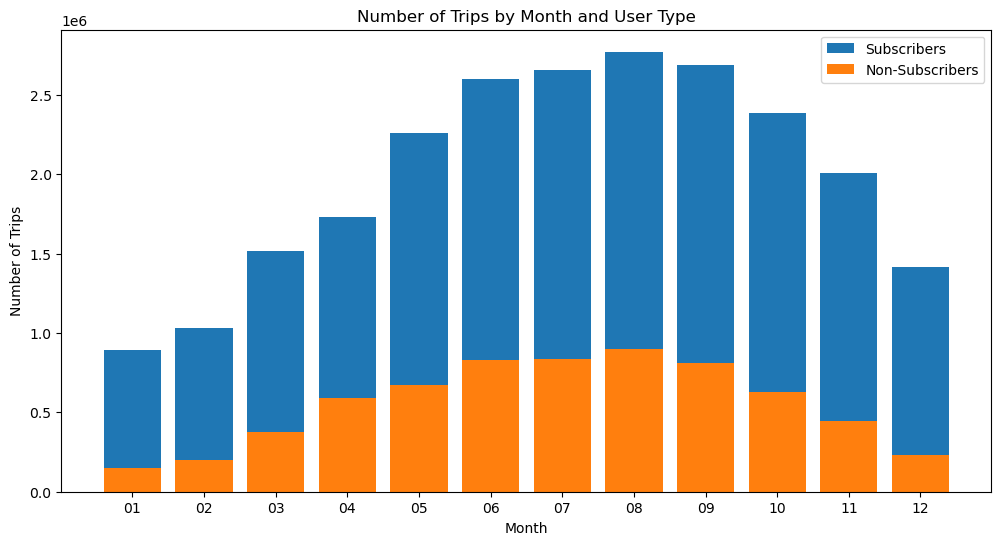

In [ ]:
df_agg = df.groupBy(F.year("started_at").alias("year"), F.month("started_at").alias("month"), "member_casual")\
           .agg(F.count("ride_id").alias("num_trips"))

df_sub = df_agg.filter(F.col("member_casual") == "member")
df_nonsub = df_agg.filter(F.col("member_casual") == "casual")

sub_data = df_sub.select("month", "num_trips").orderBy("month").collect()
nonsub_data = df_nonsub.select("month", "num_trips").orderBy("month").collect()

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar([f"{d.month:02d}" for d in sub_data], [d.num_trips for d in sub_data], label="Subscribers")
ax.bar([f"{d.month:02d}" for d in nonsub_data], [d.num_trips for d in nonsub_data], label="Non-Subscribers")

ax.set_xlabel("Month")
ax.set_ylabel("Number of Trips")
ax.set_title("Number of Trips by Month and User Type")
ax.legend()

plt.show()

The bar chart above shows the number of trips by month and user type. As the data indicates, **the highest number of trips for both subscribers and non-subscribers occurs in August, while the lowest is in January**. This trend is understandable, as people tend to use bike-sharing services more during the warmer summer months and less during the colder winter months.


**Throughout the year, the number of trips made by subscribers is consistently two to five times higher than those made by non-subscribers.** This could be attributed to a higher number of subscribers compared to non-subscribers. However, another possibility is that subscribers use the bike-sharing service more frequently than non-subscribers, leading to a higher overall number of trips. Unfortunately, the dataset does not include user IDs or any other identifiable information, that would allow us to count distinct users and determine if the higher number of trips made by subscribers is due to a larger subscriber base or higher frequency of use.



### 2.4. What's the bike usage trend for each season?

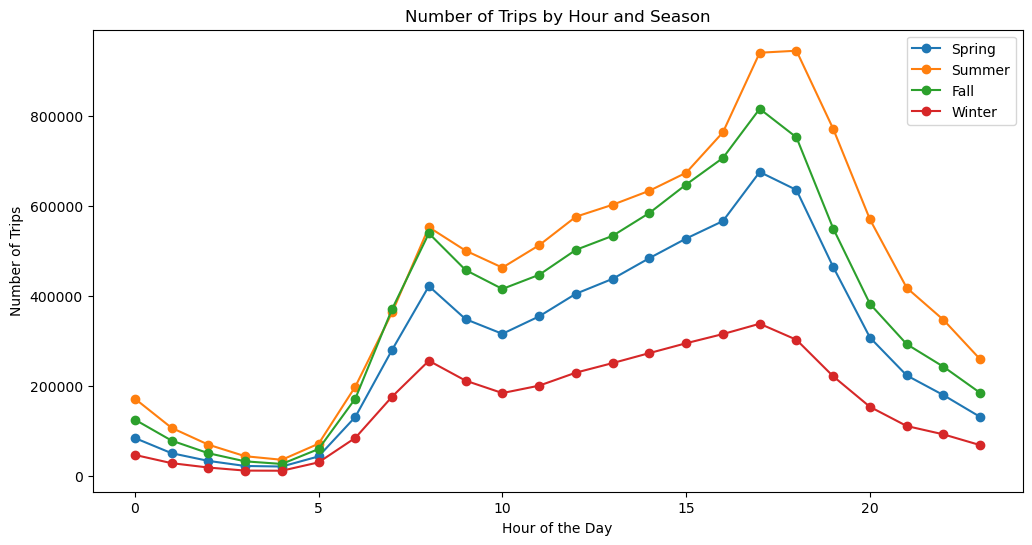

In [ ]:
df_agg_hour = df.groupBy("season", "start_hour") \
    .agg(F.count("ride_id").alias("num_trips")) \
    .orderBy("season", "start_hour")

spring_data = df_agg_hour.filter(F.col("season") == "Spring").select("start_hour", "num_trips").collect()
summer_data = df_agg_hour.filter(F.col("season") == "Summer").select("start_hour", "num_trips").collect()
fall_data = df_agg_hour.filter(F.col("season") == "Fall").select("start_hour", "num_trips").collect()
winter_data = df_agg_hour.filter(F.col("season") == "Winter").select("start_hour", "num_trips").collect()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot([d.start_hour for d in spring_data], [d.num_trips for d in spring_data], label="Spring", marker='o')
ax.plot([d.start_hour for d in summer_data], [d.num_trips for d in summer_data], label="Summer", marker='o')
ax.plot([d.start_hour for d in fall_data], [d.num_trips for d in fall_data], label="Fall", marker='o')
ax.plot([d.start_hour for d in winter_data], [d.num_trips for d in winter_data], label="Winter", marker='o')
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Number of Trips")
ax.set_title("Number of Trips by Hour and Season")
ax.legend()

plt.show()

The line plot shows the number of trips by hour for four seasons. According to the line plot, the highest number of trips occurs during the summer months, while the lowest number of trips is observed in winter. This observation can be attributed to the cold winter weather in New York, which discourages people from riding bikes.

One thing to note is that although all the seasons have two peaks at 8am and 5 pm, they show a slightly different trend. In winter, the number of trips at 5 pm is only about 10% higher than at 8 am. In contrast, during the summer, the number of trips at 5 pm nearly doubles that of 8 am. This may be attributed to the longer daylight hours experienced in the summer months. The extended daylight makes people more likely to take bike, which could account for the substantially higher number of trips at 5 pm compared to 8 am. Conversely, winter's shorter daylight hours and darker mornings and evenings lead to a more evenly distributed number of trips between the two peak times. 

### 2.5 What are the trends in usage for each bike type?

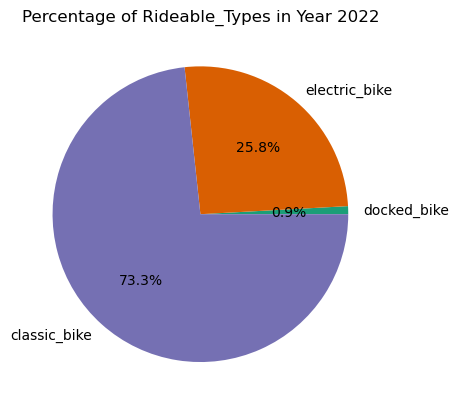

In [ ]:
rideable_counts = df.groupBy("rideable_type").count().collect()

counts = [row["count"] for row in rideable_counts]
rideable_types = [row["rideable_type"] for row in rideable_counts]

plt.pie(counts, labels=rideable_types, colors= plt.cm.Dark2.colors, autopct="%1.1f%%")
plt.title("Percentage of Rideable_Types in Year 2022")

plt.show()

Citibike offers three different types of bikes to the users. Electric bike is intuitive to understand bike with an electric motor. Classic bike and docked bike are very similar. They're both non electric and need to be docked at the station. Based on the minimal information on their website they just tried to test docked bikes which were slightly different from classic as an experiment but haven't been made permanent yet, hence the low share in the chart above.

Based on the above pie chart, we found that the classic bike has the largest market share among all rideable types in 2022, at over 70%. The recently released electric bike and docked bike services had market shares of around 25% and less than 1%, respectively. **A possible explanation for the difference in usage patterns between classic bikes and the other two types could be the availability of electric and docked bikes.** There seems to be a very limited supply of these bikes, which is preventing the number of users from rising substantially during peak periods.

Other factors that could influence the varying usage patterns include the pricing, promotion, and accessibility of each type of bike. For example, if electric and docked bikes are more expensive or less conveniently located, it could discourage users from choosing them over classic bikes. So as our next steplet's analyze the distance/duration trends for each rideable type, to get more insights on their target users.

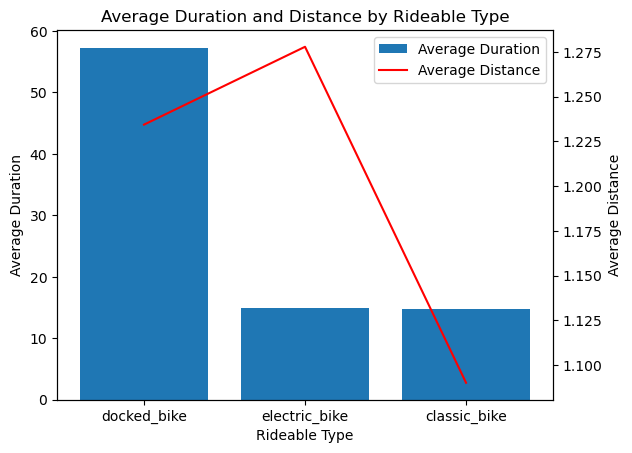

In [ ]:
avg_duration = df.groupBy("rideable_type").agg(F.avg("duration").alias("avg_duration"))
avg_distance = df.groupBy("rideable_type").agg(F.avg("distance").alias("avg_distance"))
# create a bar graph of the average of the "duration" column by "rideable_type"
rideable_types = [row[0] for row in avg_duration.collect()]
avg_durations = [row[1] for row in avg_duration.collect()]
fig, ax = plt.subplots()
ax.bar(rideable_types, avg_durations, label="Average Duration")
ax.set_xlabel("Rideable Type")
ax.set_ylabel("Average Duration")
ax.set_title("Average Duration and Distance by Rideable Type")
# create a line graph of the average of the "distance" column by "rideable_type"
avg_distances = [row[1] for row in avg_distance.collect()]
ax2 = ax.twinx()
ax2.plot(rideable_types, avg_distances, color="red", label="Average Distance")
ax2.set_ylabel("Average Distance")

# add legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=10)

plt.show()

Based on the average duration and distance by rideable type graph, we found that:
* Electric_bike has low trip duration but the longest average travel distance
We can say that these bikes are being used by riders who need to cover longer distances or who are looking for a quicker way to get to their destination. Electric bikes may be preferred by commuters who need to travel longer distances for work or other obligations.
* Classic bikes have the shortest average duration and distance
It may suggest that these bikes are being used for shorter, more casual rides or for shorter commutes. Classic bikes may be preferred by riders who are not in a hurry or who are looking for a more relaxed way to travel.
* Docked_bike has the longest average ride duration with a relatively high distance
We can say that these bikes are being used for longer, more leisurely rides or for transportation with high distant destinations. Docked bikes may also be preferred by riders who do not need to worry about time constraints, such as tourists or riders using the bike-share program for recreational purposes. However, observations on docked bikes need to be taken with a grain of salt as they are not permanent yet and experiments conducted might be creating bias in the statistics.

In conclusion, the analysis shows that different types of bikes in the Citibike NYC program are preferred for different purposes, with electric bikes being used for longer and quicker rides, classic bikes for shorter and more casual rides, and docked bikes for longer leisurely rides or transportation with high distant destinations. The findings suggest that the **program can benefit from promoting electric bikes for commuters, and classic bikes for recreational purposes**. Further analysis should be conducted on docked bikes once they become a permanent part of the program or have more data on it.


### 2.6. What are the stations that have highest trips that are both starting and ending at the same station (round trips without break)?

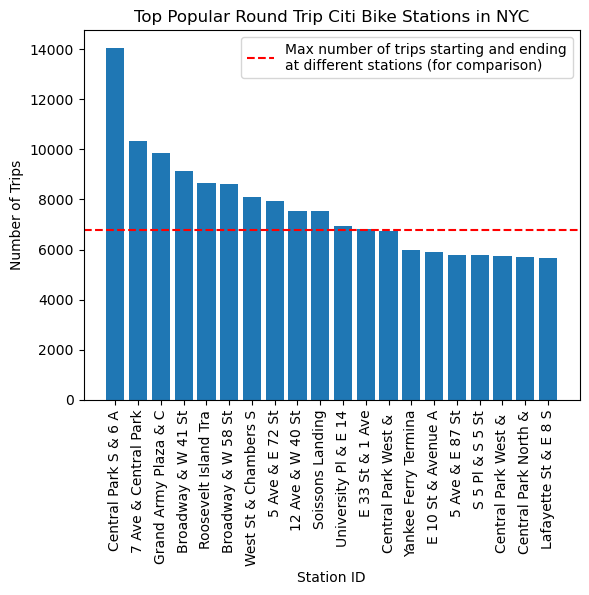

In [ ]:
grouped_trips = df.groupBy(["start_station_id","end_station_id","start_station_name"]).agg(F.count("*").alias("count"))
samestation_trips = grouped_trips.filter(grouped_trips.start_station_id == grouped_trips.end_station_id)
samestation_trips_sorted = samestation_trips.sort("count", ascending=False)

#only selecting the top 20 stations to make it more readable and converting it to pandas to plot
samestation_trips_sorted_pd = samestation_trips_sorted.limit(20).toPandas()

differentstation_trips = grouped_trips.filter(grouped_trips.start_station_id != grouped_trips.end_station_id)
max_count_differentstations = differentstation_trips.agg({"count": "max"}).collect()[0][0]

#limiting the station name to 20 characters while printing the ticks
tick_labels = [name[:20] for name in samestation_trips_sorted_pd.start_station_name]

fig, ax = plt.subplots()
ax.bar(samestation_trips_sorted_pd.index, samestation_trips_sorted_pd['count'], tick_label=tick_labels)

ax.axhline(y=max_count_differentstations, color='r', linestyle='--', label='Max number of trips starting and ending\nat different stations (for comparison)')

ax.set_xlabel('Station ID')
ax.set_ylabel('Number of Trips')
ax.set_title('Top Popular Round Trip Citi Bike Stations in NYC')
ax.legend()

plt.xticks(rotation=90)
plt.show()

**We calculated the amount of round trips(trips with same start and end station id) and regular trips(trips with different start and end station id) and we found that the most popular round trips in NYC are the ones start and end with Central Park and 7 Ave.** These 2 stations have over 10000 round trips individually with the Central Park station scoring more than 14000 trips. 

This trend makes sense because of the fact that central park is a very biking friendly zone and attracts a lot of tourists. A lot of people take quick rounds at the park as a quick workout or visitors take a quick ride around the huge park. A very interesting thing to note is that, **the max number of regular trips (shown on the chart by a dotted red line) is a lot smaller than the number of round trip stations.** This shows that a huge chunk of trips taken by users is probably for recreational purposes. This can help us improve their experience in that specific use case or drive campaigns around this.

## **3. Balance: Incoming and Outgoing Trips**

In the previous question, we did an analysis on the trips that start and end at the same station. However, the more important analysis is on trips that end at different stations from their start station as this will increase bike imbalance. For example,  if everybody commutes from the apartment to their office in the morning the docks in residential areas would be empty.

So in this section, we decided to do some analysis on the incoming and outgoing trips. First, we grouped the data appropriately and created a column that counts the number of bikes that enter and leave each station at any given time.

In [ ]:
outgoing_rides = df.groupBy('start_station_id','start_station_name','start_date', 'season', 'dayofweek', 'start_hour') \
                   .agg(F.count('started_at').alias('outgoing_bike_count'))
    
outgoing_rides.show(5)

+----------------+--------------------+----------+------+---------+----------+-------------------+
|start_station_id|  start_station_name|start_date|season|dayofweek|start_hour|outgoing_bike_count|
+----------------+--------------------+----------+------+---------+----------+-------------------+
|            5550|Bedford Ave & Nas...|2022-01-01|Winter|      Sat|        20|                  4|
|            7599|E 115 St & Madiso...|2022-01-03|Winter|      Mon|        16|                  1|
|            6254|Center Blvd & 48 Ave|2022-01-17|Winter|      Mon|        13|                  1|
|            7023|    W 59 St & 10 Ave|2022-01-31|Winter|      Mon|        20|                  4|
|            6140|     W 21 St & 6 Ave|2022-01-04|Winter|      Tue|        18|                 24|
+----------------+--------------------+----------+------+---------+----------+-------------------+
only showing top 5 rows



In [ ]:
incoming_rides = df.groupby('end_station_id','end_station_name','stop_date','season','dayofweek','stop_hour')\
                .agg(F.count('started_at').alias('incoming_bike_count'))

incoming_rides.show(5)

+--------------+--------------------+----------+------+---------+---------+-------------------+
|end_station_id|    end_station_name| stop_date|season|dayofweek|stop_hour|incoming_bike_count|
+--------------+--------------------+----------+------+---------+---------+-------------------+
|          4889| Bus Slip & State St|2022-04-13|Spring|      Wed|       17|                  7|
|          5442|Manhattan Av & Le...|2022-04-09|Spring|      Sat|       13|                  5|
|          7286|     E 91 St & 2 Ave|2022-04-02|Spring|      Sat|       16|                 12|
|          6560|  Broadway & W 38 St|2022-04-07|Spring|      Thu|        7|                 10|
|          5235|S 3 St & Bedford Ave|2022-04-25|Spring|      Mon|       19|                 13|
+--------------+--------------------+----------+------+---------+---------+-------------------+
only showing top 5 rows



Next we combine these 2 charts and plotted a bar chart of the total incoming and outgoing rides for the busy stations to analyse if there's a balance overall. 

/tmp/ipykernel_16191/3912654027.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([abs(x) for x in ax.get_xticks()])


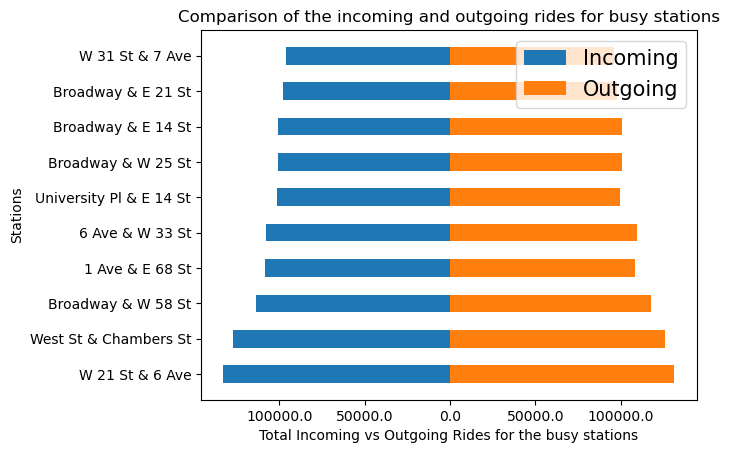

In [ ]:
incoming_agg = incoming_rides.groupby('end_station_name').sum('incoming_bike_count')
incoming_agg = incoming_agg.withColumnRenamed('sum(incoming_bike_count)', 'incoming_rides')
incoming_agg = incoming_agg.withColumnRenamed('end_station_name', 'station_name')

outgoing_agg = outgoing_rides.groupby('start_station_name').sum('outgoing_bike_count')
outgoing_agg = outgoing_agg.withColumnRenamed('sum(outgoing_bike_count)', 'outgoing_rides')
outgoing_agg = outgoing_agg.withColumnRenamed('start_station_name', 'station_name')
total_rides=incoming_agg.join(outgoing_agg,'station_name').orderBy('incoming_rides',ascending=False)
total_rides_pd = total_rides.limit(10).toPandas()

fig, ax = plt.subplots()

ax.barh(total_rides_pd.station_name, -total_rides_pd.incoming_rides, height=0.5, label='Incoming')

# Create horizontal bars for outgoing rides
ax.barh(total_rides_pd.station_name, total_rides_pd.outgoing_rides+0.5 , height=0.5, label='Outgoing')

ax.set_xlabel("Total Incoming vs Outgoing Rides for the busy stations")
ax.set_ylabel("Stations")
ax.set_title("Comparison of the incoming and outgoing rides for busy stations")
ax.legend()

ax.set_xticklabels([abs(x) for x in ax.get_xticks()])
plt.show()

We can see that the busy stations are balanced overall with a similar number of incoming and outgoing trips when calculated over a year. Although this seems like there's no imbalance, we are yet to analyze how these trends change by hour.

It's possible that during particular times like office hours of the day most trips go outward or inward creating empty docks and in turn affecting the business due to bike unavailability.

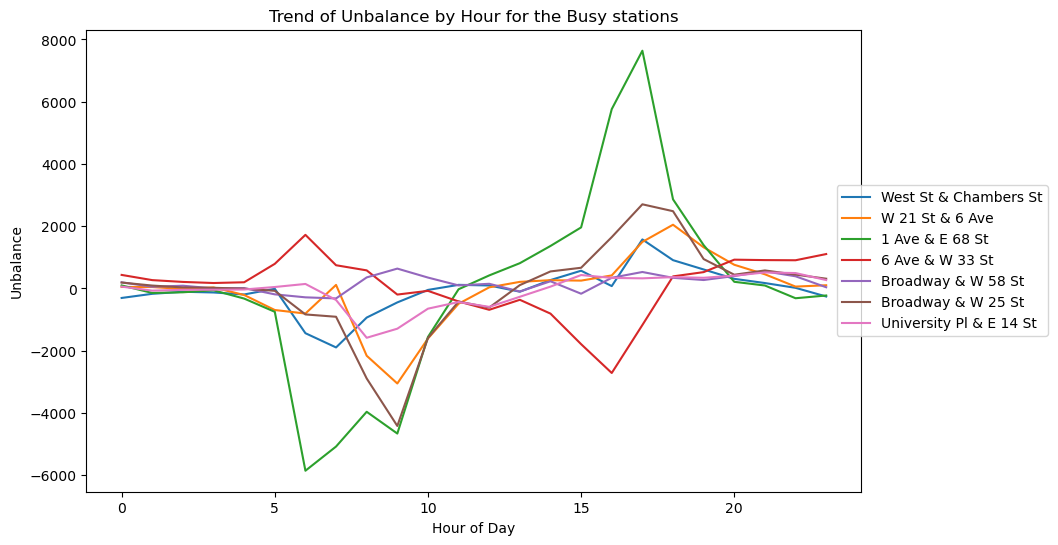

In [ ]:
incoming_agg = incoming_rides.groupby('end_station_name','stop_hour').sum('incoming_bike_count')
incoming_agg = incoming_agg.withColumnRenamed('sum(incoming_bike_count)', 'incoming_rides')
incoming_agg = incoming_agg.withColumnRenamed('end_station_name', 'station_name')
incoming_agg = incoming_agg.withColumnRenamed('stop_hour', 'hour')

outgoing_agg = outgoing_rides.groupby('start_station_name','start_hour').sum('outgoing_bike_count')
outgoing_agg = outgoing_agg.withColumnRenamed('sum(outgoing_bike_count)', 'outgoing_rides')
outgoing_agg = outgoing_agg.withColumnRenamed('start_station_name', 'station_name')
outgoing_agg = outgoing_agg.withColumnRenamed('start_hour', 'hour')

unbalanced_rides=incoming_agg.join(outgoing_agg,['station_name','hour'],'inner').orderBy('incoming_rides',ascending=False)
unbalanced_rides=unbalanced_rides.withColumn('unbalance',col('outgoing_rides')-col('incoming_rides'))


unbalanced_rides_pd = unbalanced_rides.toPandas()
unbalanced_rides_pd = unbalanced_rides_pd[unbalanced_rides_pd['station_name'].isin(total_rides_pd.station_name.head(7))]

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='hour', y='unbalance', hue='station_name', data=unbalanced_rides_pd)

# Set plot title and labels
plt.title('Trend of Unbalance by Hour for the Busy stations')
plt.xlabel('Hour of Day')
plt.ylabel('Unbalance')
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

As expected some important observations from the graph above are aware that stations line 1st Avenue(green line) has much higher outgoing bikes than incoming in the evening times and vice versa in the morning. Stations like 6th Avenue follow the opposite trend. This is because most offices tend to be clustered in similar places and similarly resedential spaces. This knowledge could be used to optimize bike availability at those stations during peak usage times.

One possible action step based on this observation is **to use dynamic rebalancing of bikes between stations to ensure that there are enough bikes available for users during peak times**. For example, if a particular station has a high number of outgoing bikes during the morning rush hour, additional bikes could be transported to that station from nearby stations with excess bikes. Similarly, if a particular station has a high number of incoming rides during the evening rush hour, bikes could be transported from that station to nearby stations with lower bike availability.

By using dynamic rebalancing to optimize bike availability at stations, Citibike NYC could improve the user experience and attract more subscribers by ensuring that bikes are available when and where they are needed most. This approach could also help reduce the number of bikes that are left unused at stations with excess bike availability, thus reducing the need for bike redistribution and maintenance.

## **4. Clustering**

Let's try to cluster the stations into high and low demand clusters so that it'll be easy for us to build strategies based on the group the station belongs to.

It's important to note that the trend of rides keeps changing with hour so getting the data for each station for each hour will help us cluster these stations better. Hence we create the pivot table as needed in this step.

In [ ]:
cluster_input = df.groupby(['start_station_id', 'start_hour']).count()
pivot_input = cluster_input.groupBy("start_station_id").pivot("start_hour").sum("count")
cluster_input = pivot_input.withColumnRenamed('start_station_id', 'index').orderBy('index').dropna()
cluster_input.show(5)

23/05/01 09:02:31 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|index|  0|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10| 11| 12| 13| 14| 15| 16| 17| 18| 19| 20| 21| 22| 23|
+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 2733| 19| 14| 13| 10| 11|  6| 47| 39| 70| 70| 82|119|168|163|158|228|182|189|178|155|145| 71| 56| 56|
| 2782| 40| 25| 18|  9| 19|  7| 58| 48| 86| 91|100|145|145|169|272|211|284|342|325|305|235|198|144| 90|
| 2832| 31| 12| 10| 11|  7| 16| 77|111|197|221|176|188|166|205|341|306|281|258|246|174|128|108|105| 54|
| 2872|  3|  5|  4|  2|  2|  2|  7| 15| 44| 69| 58| 52| 39| 64| 59| 65| 72| 79| 44| 43| 24| 26| 14| 12|
| 2883| 33| 16| 17|  8| 10| 17| 39| 28| 84| 81|107| 96|113|130|144|154|153|173|125|130| 90| 75| 71| 45|
+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
only showing top 5 rows



### 4.1. Standardization

Standardizing the values really helps improve the performance of a kmeans clustering. So we standardize them by first creating a vector using VectorAssembler() and then scaling them.

In [ ]:
column_names = cluster_input.columns
column_names.remove('index')

va = VectorAssembler().setInputCols(column_names).setOutputCol('features').setHandleInvalid("skip")
vector_data=va.transform(cluster_input)

sScaler = StandardScaler(inputCol="features",outputCol="scaled_features", withMean=True, withStd=True)
scaled_data=sScaler.fit(vector_data).transform(vector_data)

### 4.2. Evaluting which k to choose
First we decide on the number of clusters. Choosing the optimal number of clusters helps to ensure that the clustering model is not underfit (too few clusters) or overfit (too many clusters), but is instead just right for the dataset being analyzed. Hence' we use two plots to decide on this value.


#### 4.2.1 Elbow curve
The elbow curve is a graphical tool that helps us in determining the optimal number of clusters (K) to use in the analysis. The curve is created by plotting the number of clusters (K) against the sum of squared distances of each point to its nearest cluster center, also known as the "cost" in the pyspark library we're using.

The idea behind the elbow curve is to identify the "elbow" point, which is the point of inflection in the curve. This point represents the optimal number of clusters, beyond which the gain in clustering performance decreases at a decreasing rate. In other words, the elbow point is the point where adding more clusters does not improve the clustering performance significantly.

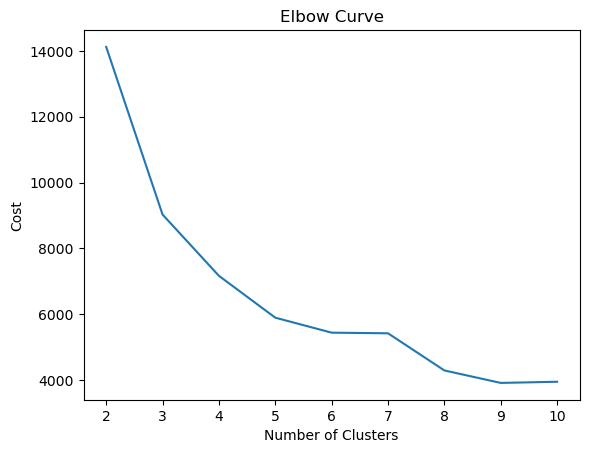

In [ ]:
evaluator = ClusteringEvaluator()

cost_list = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol="scaled_features", k=k)
    model = kmeans.fit(scaled_data)
    cost = model.summary.trainingCost
    cost_list.append(cost)
    
# Plot the silhoutte curve
plt.plot(range(2, 11),cost_list)
plt.xlabel("Number of Clusters")
plt.ylabel("Cost")
plt.title("Elbow Curve")
plt.show()

We can see that we've two elbow points one at 3 and another at 5. Although 5 seems like a better elbow point from this graph we feel that 5 different types of stations might become very hard for us to optimize for in terms of the bueinsss. Having 3 clusters of high, medium and low depleton rate would be easier to handle so k=3 seems ideal so far.

#### 4.2.2 Silhouette Score

The silhouette score plot is useful for identifying clusters that are well-separated and compact i.e. how well a data points fits into a cluster, and for identifying outliers or misclassified data points. A higher average silhouette score across all clusters indicates better clustering performance, while a lower average score suggests that the data points are not well-clustered. Overall, the silhouette score plot helps to visually evaluate the quality of the clustering algorithm and fine-tune the number of clusters for better clustering performance.

We can compare the score mainly for 3 and 5 to clear our confusion from the previous method.

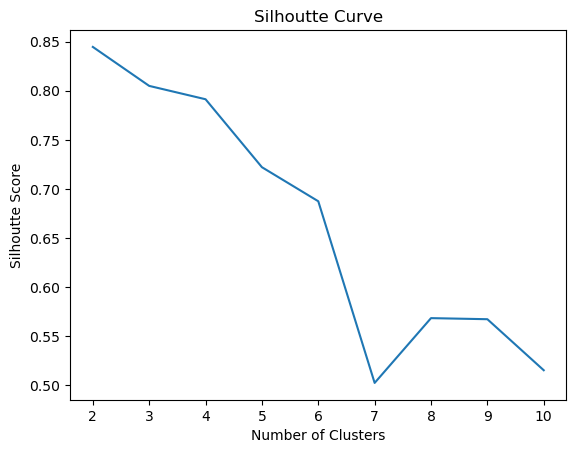

In [ ]:
evaluator = ClusteringEvaluator()

silhoutte_list = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol="scaled_features", k=k)
    model = kmeans.fit(scaled_data)
    predictions = model.transform(scaled_data)
    silhoutte_score = evaluator.evaluate(predictions)
    silhoutte_list.append(silhoutte_score)
    
    # Plot the silhoutte curve
plt.plot(range(2, 11),silhoutte_list)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")
plt.title("Silhoutte Curve")
plt.show()

We can see that k=3 has a relatively higher silhouette score compared to k=5. So our choise to pick k=3 is strengthened with this graph.

### **4.2.3 k-means clustering**

Now that we've chosen an optimal k we perform k-means clustering operation to create 3 clusters and then print the corresponding silhouette score.

We also merge these predictions with our original dataset to visualize these cluster formations

In [ ]:
# Trains a k-means model.
kmeans = KMeans(featuresCol="scaled_features",k=3, seed=843)
model = kmeans.fit(scaled_data)
evaluator = ClusteringEvaluator()

# Make predictions
predictions = model.transform(scaled_data)

# Evaluate clustering by computing Silhouette score
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

#merging our cluster predictions with our dataframe to visualize our clusters based on various parametrs
predictions_joined = df.join(predictions.select(col('index'),col('prediction')), 
                                predictions.index == df.start_station_id)

23/05/01 09:02:49 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/01 09:02:49 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Silhouette with squared euclidean distance = 0.8025166757104373


### 4.2.4. Cluster Plots

We'll plot these formed clusters to analyse their formation and make meaning out of it.

Since we built our clusters mainly based on their demand in different parts of the day let's first vsiualize average demand in different clusters through the day.

Text(0.5, 1.0, 'Distribution of trips through the day in each Cluster')

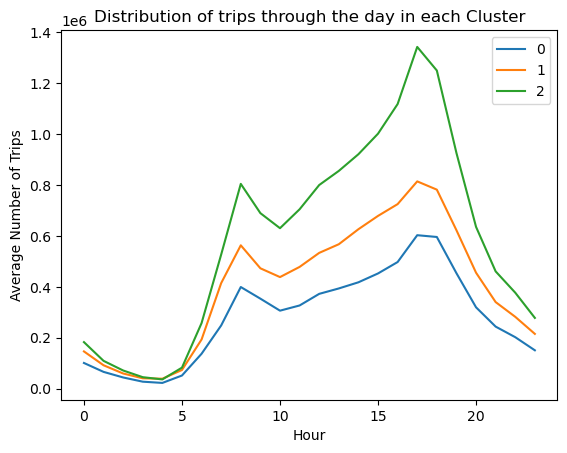

In [ ]:
cluster_predictions = predictions_joined.groupBy("prediction", "start_hour")\
                     .agg({"ride_id": "count"}).withColumnRenamed("count(ride_id)", "avg_trips")


# Pivot the dataframe to create a line chart
pivot_predictions = cluster_predictions.groupBy("start_hour").pivot("prediction").sum("avg_trips").orderBy("start_hour")

# Show the dataframe to check the results
pivot_predictions.toPandas().plot(kind="line", x="start_hour")
plt.xlabel("Hour")
plt.ylabel("Average Number of Trips")
plt.title("Distribution of trips through the day in each Cluster")

We can notice how beautifully these clusters have been divided. They follow the same overall pattern as peaks would be similar for all clusters in busy hours but are divided by demand. Notably, Cluster 2 exhibits high demand stations, Cluster 1 displays medium demand stations, and Cluster 0 represents low demand stations. 

Servicing high demand stations more frequently can help ensure that the stations are always functioning optimally, thereby reducing the likelihood of service disruptions and customer dissatisfaction. Regular maintenance and servicing can also extend the lifespan of the equipment and prevent the need for costly repairs or replacements.

On the other hand, low demand stations may not require frequent servicing, as the low volume of traffic means that the equipment may not experience as much wear and tear. However, it is important to note that neglecting these stations altogether can result in equipment failure or other issues that could potentially cause inconvenience to customers.

Another important factor to check is the change in station usage based on the day of the week. To ensure the reliability of our conclusions, it is crucial for the clusters to follow a similar trend by weekday as well. Therefore, we plotted the clusters against each day of the week.


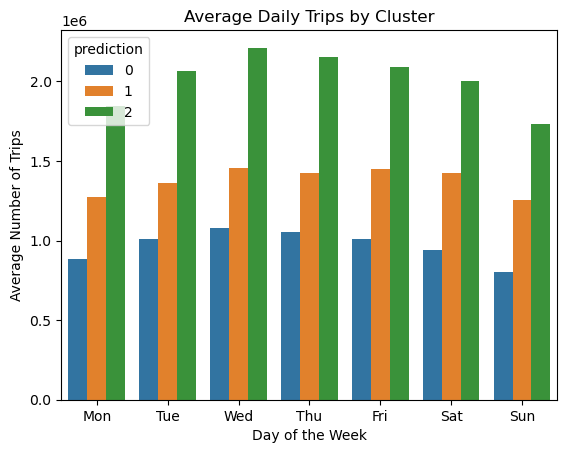

<Figure size 1500x800 with 0 Axes>

In [ ]:
cluster_predictions_2 = predictions_joined.groupBy("prediction", "dayofweek")\
                     .agg({"ride_id": "count"}).withColumnRenamed("count(ride_id)", "avg_trips")


order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

sns.barplot(x="dayofweek", y="avg_trips", hue="prediction", data=cluster_predictions_2.toPandas(), order=order)

plt.xlabel("Day of the Week")
plt.ylabel("Average Number of Trips")
plt.title("Average Daily Trips by Cluster")
plt.figure(figsize=(15, 8))
plt.show()

Again similar to the previous step cluster 2 remains the high demand cluster and cluster 0 low demand. The overall trend stains consistent in all 3 based on the week day. This segregation can be very useful  for developing strategies as discussed before.

Let's now visualize our clusters based on geographial location to see if they are clustered close by.

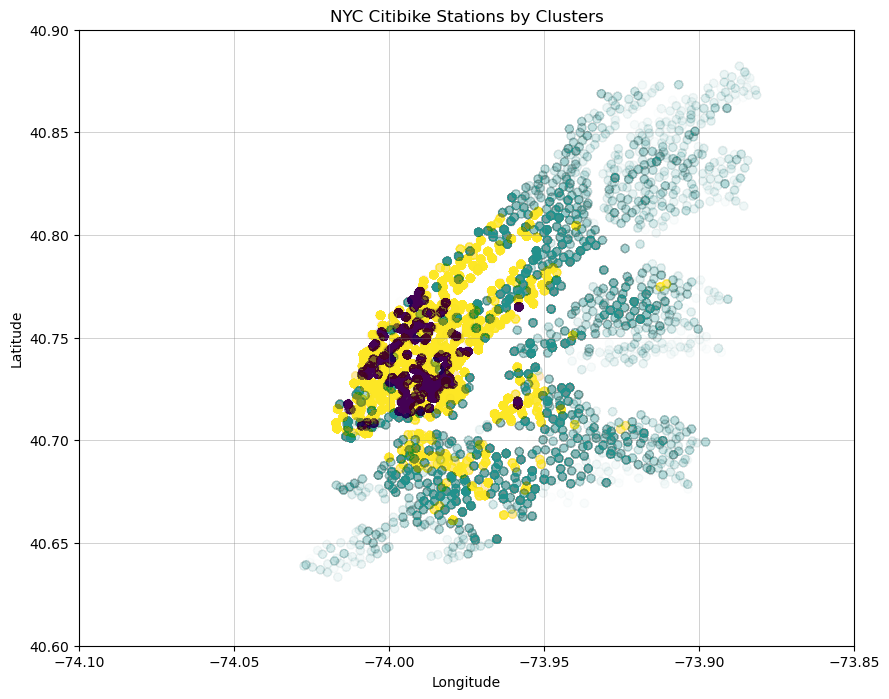

In [ ]:
predictions_sample = predictions_joined.select('start_lng', 'start_lat', 'prediction').sample(False, 0.005)

prediction_pandas = predictions_sample.toPandas()

plt.figure(figsize=(10,8))
plt.scatter(prediction_pandas['start_lng'], prediction_pandas['start_lat'], alpha=0.009, 
            c=prediction_pandas['prediction'])
plt.xlim(-74.1, -73.85)
plt.ylim(40.6, 40.9)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NYC Citibike Stations by Clusters')
plt.grid(linestyle='-', linewidth='0.5', color='gray', alpha=0.5)
plt.show()

Based on the above graph, it is evident that the clusters have been effectively segregated by demand and location. Although it loks like there is some overlap between the clusters, this is mainly due to our focus on segregating them by demand and not incorporating location coordinates as a significant feature.

The cluster comprising the Central Park area is distinct from the office area cluster, which is followed by locations that are further away and predominantly residential. Given the high concentration of the first two clusters, it would be feasible for the maintenance team to inspect the stations simulatneously, thereby reducing the overall inspection time.

Overall, the clustering approach has provided valuable insights into the spatial distribution of demand and location, which can inform decision-making processes and resource allocation strategies for efficient maintenance and service delivery.

## **Summary**
The project analyzed and visualized trends and patterns in Citibike NYC rides in 2022. Here are a few action steps we recommend - 

* **Optimizing resources for the most popular round trips:** Since it was observed that the most popular round trips in NYC are the ones starting and ending with Central Park and 7 Ave, efforts can be made to optimize resources such as bike availability, station capacity, and service frequency in those areas during peak usage times (Tuesday, Wednesday, and Thursday, between 5:00 PM and 6:00 PM).
* **Promoting the use of electric bike services:** Although classic bikes had the largest market share among all rideable types in 2022, efforts can be made to promote the use of recently released electric bike services, especially during off-peak periods when bike availability is high. This could be achieved through targeted marketing campaigns and discounted pricing for these services.

* **Focusing on subscriber retention and acquisition**: Since the highest number of trips for both subscribers and non-subscribers occurred in August, efforts can be made to retain existing subscribers and acquire new ones by offering incentives such as discounted subscription rates, loyalty rewards, and improved customer service.

* **Balancing Strategy**- A few stations like 1st avenue and 6th avenue have a high imbalance where outgoing bikes were more than incoming rides at particular times of the day, and vice versa at others. This knowledge can help us implement dynamic rebalancing to optimize bike availability at stations with more outgoing bikes than incoming rides at certain times of the day.

* **Utilizing clustering to optimize station servicing**: By analyzing the clustering of stations based on demand, it was observed that high demand stations should be serviced and maintained more frequently, while low demand stations can be serviced less frequently to optimize time and resources.

* **Improving infrastructure in downtown areas**:Since most busy stations were observed to be flocked together in downtown NY with docks becoming mostly empty, efforts can be made to improve infrastructure  such as increasing station capacity, adding more bike docks, and optimizing bike availability during peak usage times or adopting baalncing startegies as discussed above.


## **Challenges Faced**

Here are a few challenges that slowed down our project-

* Dataset Size and Accessibility: The sheer size of the Citi Bike NYC dataset and the way it was organzied (by each month) made it difficult to manage the merging efficiently. Moreover, the dataset was not readily available on Google BigQuery, which required additional effort to load and prepare the data for analysis.

* Business Knowledge: The website that provided the dataset had limited information, and it was challenging to understand certain aspects of the data For Eg- they did not provide clear information on the different bike types (classic/docked) or the subscription model (e.g., whether monthly passes are considered as membership or only the yearly passes). We had to go through various blogs and websites to fully understand what they mean.

* Spark Load Balancing Issues: As a result of the dataset's large size, the Apache Spark platform was utilized for processing. However, the project was hindered by frequent load balancing issues, leading to delays and disruptions in the analysis process.

* Unclear Error Messages: Throughout the project, some errors encountered in Spark were ambiguous, making it challenging to identify and resolve the issues promptly. This caused debugging to consume a significant amount of time, further delaying the overall progress of the EDA.



## **References**
* PySpark documentation: https://spark.apache.org/docs/latest/api/python/
* NYC Citi Bike system data: https://www.citibikenyc.com/system-data
* NYC Open Data portal: https://opendata.cityofnewyork.us/
* Python Seaborn library documentation: https://seaborn.pydata.org/
* Python Pandas library documentation: https://pandas.pydata.org/
* ChatGPT- to fix a few errors in the code and help understand a few functions and it's arguments better.


